In [6]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from adjustText import adjust_text
from matplotlib.patches import FancyArrowPatch

In [7]:
species_dict = {
    'GSE136689' : 'mmusculus',
    'GSE162534' : 'mmusculus',
    'GSE201257' : 'mmusculus',
    'GSE229103' : 'mmusculus'
    }

adata_fn = sorted(glob.glob('../data/processed/*/*.h5ad'))
adata_dict = {fn.split('/')[-1].split('_')[0] : fn for fn in adata_fn}
for key in adata_dict:
    adata_dict[key] = sc.read_h5ad(adata_dict[key])
    print(key, adata_dict[key])

GSE136689 AnnData object with n_obs × n_vars = 10097 × 17462
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype'
    var: 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'Stages_colors', 'celltype_colors', 'diffmap_evals', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
GSE162534 AnnData object with n_obs × n_vars = 8725 × 19013
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
GSE201257 Ann

In [8]:
adata_bulk_dict = adata_dict.copy()
for key in adata_dict:
    adata_key = adata_dict[key][~adata_dict[key].obs.celltype.isna()]
    adata_bulk_dict[key] = sc.get.aggregate(adata_key, 'celltype', 'mean')
    print(key, adata_bulk_dict[key])

GSE136689 AnnData object with n_obs × n_vars = 8 × 17462
    obs: 'celltype'
    var: 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    layers: 'mean'
GSE162534 AnnData object with n_obs × n_vars = 3 × 19013
    obs: 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    layers: 'mean'
GSE201257 AnnData object with n_obs × n_vars = 12 × 21676
    obs: 'celltype'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    layers: 'mean'
GSE229103 AnnData object with n_obs × n_vars = 7 × 20088
    obs: 'celltype'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    layers: 'mean'


In [9]:
signature_fn = sorted(glob.glob('../03_signatures/results/*/*/*.txt'))
signature_dict = {'_'.join([fn.split('/')[i] for i in [-3, -1]]).replace('.txt', '') : fn for fn in signature_fn}
for key in signature_dict:
    signature_dict[key] = pd.read_csv(signature_dict[key])
    print(key, signature_dict[key])

GSE136689_early    mmusculus hsapiens
0       Dab2     DAB2
1      Map1b    MAP1B
2       Irx1     IRX1
3      Rbm24    RBM24
4      Sox11    SOX11
..       ...      ...
65     Nop58    NOP58
66     Aldoa    ALDOA
67       Mmd      MMD
68   Slc16a3  SLC16A3
69    Mpped2   MPPED2

[70 rows x 2 columns]
GSE136689_late    mmusculus hsapiens
0        Id2      ID2
1     Homer2   HOMER2
2       Manf     MANF
3       Bex2     BEX1
4       Bex2     BEX2
5       Bex1     BEX1
6       Bex1     BEX2
7      Nr2f2    NR2F2
8       Wnt2     WNT2
9       Alx1     ALX1
10     Csrp2    CSRP2
11     Sfrp1    SFRP1
12      Krt8     KRT8
13     Krt18    KRT18
14    Phlda1   PHLDA1
15      Osr1     OSR1
16      Mycn     MYCN
17      Rbp1     RBP1
18     Gata6    GATA6
19     Sfrp5    SFRP5
20     Rras2    RRAS2
21     Pmp22    PMP22
22     Cox17    COX17
23    Popdc2   POPDC2
24       Ddt     DDTL
25       Ddt      DDT
26   Smarcd3  SMARCD3
27      Ly6e     LY6E
28      Nrp1     NRP1
29     Dusp9    DUSP9


In [10]:
df_ix = np.concatenate([adata_bulk_dict[key].obs.celltype for key in adata_bulk_dict])
df_col = np.asarray(signature_dict.keys())
df = pd.DataFrame(0., index = df_ix, columns = df_col)
for key in adata_bulk_dict:
    adata = adata_bulk_dict[key]
    for col in df.columns:
        signature = signature_dict[col][species_dict[key]]
        df.loc[adata.obs.celltype, col] = sc.tl.score_genes(
            adata, signature, ctrl_as_ref = True, score_name = col,
            copy = True, layer = 'mean').obs[col]
df_norm = df.apply(zscore)

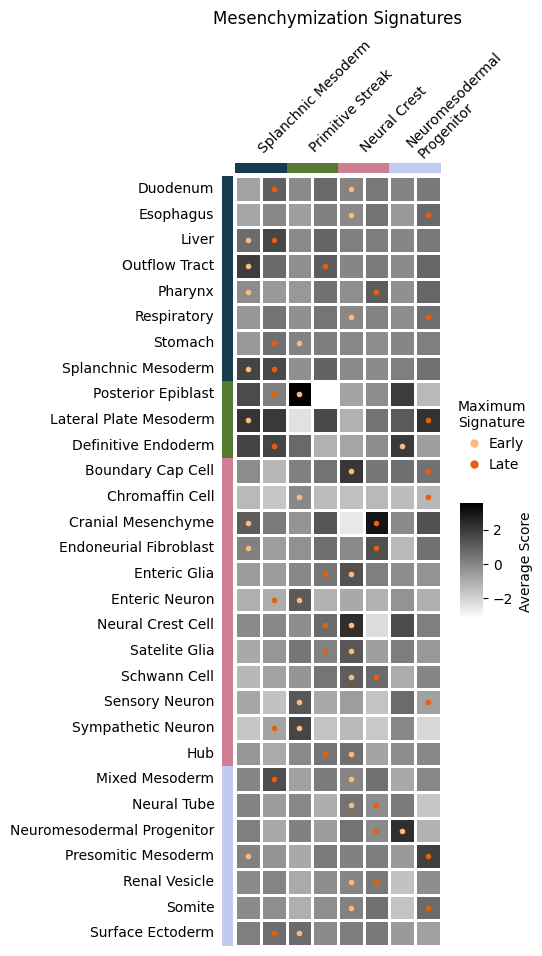

In [12]:
# signatures heatmap
col_cat = np.flip(np.vstack(df.columns.str.split('_')), 1)
col_cat = pd.DataFrame(col_cat, index = df.columns, columns = ['stage', 'GEO'])
row_cat = np.concatenate([[key] * adata_bulk_dict[key].shape[0] for key in adata_bulk_dict])
row_cat = pd.Series(row_cat, index = df.index, name = 'GEO')
stages = col_cat.stage.unique()
dsets = col_cat.GEO.unique()

stage_cdict = dict(zip(stages, sns.color_palette('Oranges', stages.size)))
dset_cdict = dict(zip(dsets, sns.color_palette('cubehelix', dsets.size)))
row_colors = row_cat.map(dset_cdict).values
col_colors = col_cat.GEO.map(dset_cdict).values

lw, cw, cbar_dict = 1, .4, {'label' : 'Average Score', 'shrink' : .15, 'aspect' : 5}
fig, ax = plt.subplots(1, 1, figsize = (5, 10))
sns.heatmap(df_norm, cmap = 'binary', square = True, cbar_kws = cbar_dict, linewidths = lw, linecolor = 'w', ax = ax)

for kind in ('row', 'column'):
    if kind == 'row':
        w, h, cc = cw, 1, row_colors
        xx = np.full(df.shape[0], -cw - .1)
        yy = np.arange(df.shape[0])
    else:
        w, h, cc = 1, cw, col_colors
        xx = np.arange(df.shape[1])
        yy = np.full(df.shape[1], -cw - .1)
    for x, y, c in zip(xx, yy, cc):
        ax.add_patch(Rectangle(
            (x, y), w, h, 
            facecolor = c, 
            edgecolor = 'none',
            transform = ax.transData,
            clip_on = False))

stage_legend = [None] * stages.size
for i, stage in enumerate(stages):
    msk_stage = (col_cat.stage == stage)
    c = stage_cdict[stage]
    for y, ix in enumerate(df.index):
        max_signature = df_norm.loc[ix, msk_stage].idxmax()
        x = np.where(df.columns == max_signature)[0][0] + .5
        ax.scatter(x, (y + .5), marker = '.', color = c)
    stage_legend[i] = Line2D(
        [0], [0], marker = '.',  
        markersize = 10, 
        label = stage.capitalize(), 
        color = 'none', 
        markerfacecolor = c, 
        markeredgecolor = c)
    
ax.legend(handles = stage_legend,
          title = 'Maximum\nSignature',
          loc = 'lower center',
          bbox_to_anchor = (1.25, .6),
          frameon = False,
          handletextpad = 0)

dset_labels = {
    'GSE201257' : 'Neural Crest',
    'GSE229103' : 'Neuromesodermal\nProgenitor',
    'GSE136689' : 'Splanchnic Mesoderm',
    'GSE162534' : 'Primitive Streak'}

xticks = np.arange(0, df.shape[1], 2) + 1
xticklabels = [dset_labels[dset] for dset in dsets]
ax.set_xticks(xticks, xticklabels, rotation = 45, rotation_mode = 'anchor', ha = 'left', va = 'center')
ax.tick_params('x', bottom = False, labelbottom = False, labeltop = True, pad = 15)

ax.set_ylabel('')
ax.tick_params('y', size = 0, pad = 15)
ax.set_title('Mesenchymization Signatures', pad = 10)
plt.show()

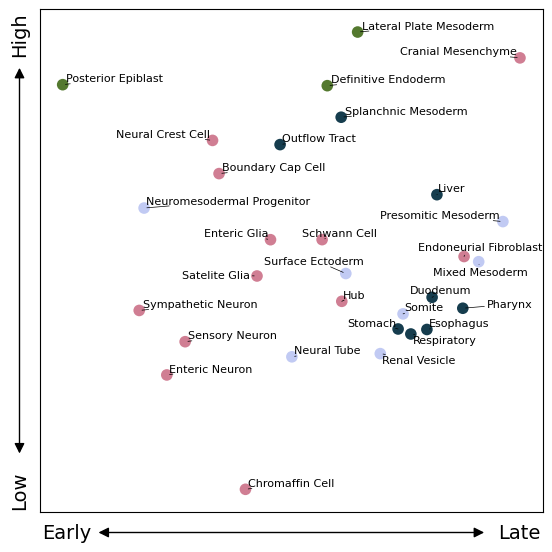

In [18]:
# mesenchymization spectrum
df_mes = df_norm.T.copy()
df_mes['stage'] = col_cat.stage
df_mes = df_mes.groupby('stage').max().T
df_mes['avg'] = df_mes.mean(1)
df_mes['diff'] = np.diff(df_mes[stages])
df_mes['c'] = row_colors

ms, fs, fw = 70, 8, 5.33
fig, ax = plt.subplots(1, 1, figsize = (fw, fw))
df_mes.plot.scatter('diff', 'avg', ms, 'c', lw = 0, ax = ax)

labels = [None] * df_mes.shape[0]
for i, ix in enumerate(df_mes.index):
    labels[i] = plt.text(*df_mes.loc[ix, ['diff', 'avg']], ix, fontsize = fs, ha = 'center', va = 'center')
adjust_text(labels, arrowprops = {'arrowstyle' : '-', 'color' : 'k', 'lw' : .5})

label_offset, arrow_offset, text_offset = -.01, .133, .033
for axis in ('x', 'y'):
    if axis == 'x':
        start, end = (arrow_offset, label_offset), (1 - arrow_offset, label_offset)
        text1 = (text_offset, label_offset, 'Early', 'left', 'center', 0)
        text2 = (1 - text_offset, label_offset, 'Late', 'right', 'center', 0)
    else:
        start, end = (label_offset, arrow_offset), (label_offset, 1 - arrow_offset)
        text1 = (label_offset, text_offset, 'Low', 'center', 'bottom', 90)
        text2 = (label_offset, 1 - text_offset, 'High', 'center', 'top', 90)
    arrow = FancyArrowPatch(start, end, arrowstyle = '<|-|>', color = 'k', mutation_scale = 15, transform = fig.transFigure)
    fig.patches.append(arrow)
    for x, y, s, ha, va, rot in (text1, text2):
        fig.text(x, y, s, ha = ha, va = va, rotation = rot, fontsize = 14)

ax.set_xticks([])
ax.set_xlabel('')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_box_aspect(1)

plt.tight_layout()
plt.show()